In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import time
import matplotlib.pyplot as plt
import random

In [ ]:
train = pd.read_csv('train_secco_adige.csv')
test = pd.read_csv('test_umido_adige.csv')

In [ ]:
A14_15_10_22 = pd.read_csv('A14_15_10_22_con332.csv')
A1218_16_17 = pd.read_csv('A1218_16_17_con332.csv')
A1320_11_19_21 = pd.read_csv('A1320_11_19_21_con332.csv')


In [ ]:
B10_15_17_22 = pd.read_csv('B10_15_17_22.csv')
B1218_16 = pd.read_csv('B1218_16.csv')
B1319_21 = pd.read_csv('B1319_21.csv')
B1420_11 = pd.read_csv('B1420_11.csv')


In [ ]:
K10_16_21 = pd.read_csv('K10_16_21_s687281.csv')
K1218_17_22 = pd.read_csv('K1218_17_22_s687281.csv')
K1319_15 = pd.read_csv('K1319_15_s687281.csv')
K1420_11 = pd.read_csv('K1420_11_s687281.csv')

In [ ]:
def reshape_without_waterflow(train, test, n_timesteps_in, n_timesteps_out):
  sc = StandardScaler()
  X_train = sc.fit_transform(train.values)[:,:-1]
  X_test = sc.transform(test.values)[:,:-1]
  X_train = torch.tensor(X_train).float()
  X_test = torch.tensor(X_test).float()
  y_train = torch.tensor(train.values)[:,-1].float()
  y_test = torch.tensor(test.values)[:,-1].float()
  y_train = y_train.view(y_train.shape[0], 1)
  y_test = y_test.view(y_test.shape[0], 1)

  def reshape_data(x, y, past, fut, lag):
      num_samples, num_features = x.shape
      x_new = np.zeros((num_samples - past + 1 -fut -lag, past, num_features)).astype('float32')
      y_new = np.zeros((num_samples - past + 1 -fut -lag, fut, 1)).astype('float32')
      print(x_new.shape)
      for i in range(0, x_new.shape[0]):
          x_new[i, :, :num_features] = x[i:i + past, :]
          y_new[i, :, :] = y[i + past - 1 + lag : i + past -1 + lag + fut , 0].view(fut,1)
      return x_new, y_new

  X_test_new, y_test_new = reshape_data(X_test, y_test, n_timesteps_in, n_timesteps_out, 1)
  X_train_new, y_train_new = reshape_data(X_train, y_train, n_timesteps_in, n_timesteps_out, 1)
  return X_train_new, y_train_new, X_test_new, y_test_new

def reshape_with_waterflow(train, test, n_timesteps_in, n_timesteps_out):
  sc = StandardScaler()
  X_train = sc.fit_transform(train.values)
  X_test = sc.transform(test.values)
  X_train = torch.tensor(X_train).float()
  X_test = torch.tensor(X_test).float()
  y_train = torch.tensor(train.values)[:,-1].float()
  y_test = torch.tensor(test.values)[:,-1].float()
  y_train = y_train.view(y_train.shape[0], 1)
  y_test = y_test.view(y_test.shape[0], 1)

  def reshape_data(x, y, past, fut, lag):
      num_samples, num_features = x.shape
      x_new = np.zeros((num_samples - past + 1 -fut -lag, past, num_features)).astype('float32')
      y_new = np.zeros((num_samples - past + 1 -fut -lag, fut, 1)).astype('float32')
      print(x_new.shape)
      for i in range(0, x_new.shape[0]):
          x_new[i, :, :num_features] = x[i:i + past, :]
          y_new[i, :, :] = y[i + past - 1 + lag : i + past -1 + lag + fut , 0].view(fut,1)
      return x_new, y_new

  X_test_new, y_test_new = reshape_data(X_test, y_test, n_timesteps_in, n_timesteps_out, 1)
  X_train_new, y_train_new = reshape_data(X_train, y_train, n_timesteps_in, n_timesteps_out, 1)
  return X_train_new, y_train_new, X_test_new, y_test_new

def reshape_with_predictions(train, test, n_timesteps_in, n_timesteps_out):
  sc = StandardScaler()
  X_train = sc.fit_transform(train.values)
  X_test = sc.transform(test.values)
  X_train = torch.tensor(X_train).float()
  X_test = torch.tensor(X_test).float()

  # X_train = torch.tensor(train.values).float()
  # X_test = torch.tensor(test.values).float()

  y_train = torch.tensor(train.values)[:,-1].float()
  y_test = torch.tensor(test.values)[:,-1].float()
  y_train = y_train.view(y_train.shape[0], 1)
  y_test = y_test.view(y_test.shape[0], 1)

  def reshape_data_with_predictions(x, y, past, fut, lag):
      num_samples, num_features = x.shape
      x_new = np.zeros((num_samples - past + 1 -fut -lag, past, num_features)).astype('float32')
      preds = np.zeros((num_samples - past + 1 -fut -lag, fut, num_features - 1)).astype('float32')
      y_new = np.zeros((num_samples - past + 1 -fut -lag, fut, 1)).astype('float32')
      print(x_new.shape)
      for i in range(0, x_new.shape[0]):
          x_new[i, :, :num_features] = x[i:i + past, :]
          preds[i, :, :] = x[i + past - 1 + lag : i + past -1 + lag + fut , :-1]
          y_new[i, :, :] = y[i + past - 1 + lag : i + past -1 + lag + fut , 0].view(fut,1)
      return x_new, y_new, preds

  X_test_new, y_test_new, preds_test = reshape_data_with_predictions(X_test, y_test, n_timesteps_in, n_timesteps_out, 1)
  X_train_new, y_train_new, preds_train = reshape_data_with_predictions(X_train, y_train, n_timesteps_in, n_timesteps_out, 1)
  print('these be the shapes', X_train_new.shape, y_train_new.shape, preds_train.shape)
  return X_train_new, y_train_new, preds_train, X_test_new, y_test_new, preds_test

class ArpavData(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.x)

class Model_preds(nn.Module):
    """MODEL WITH PREDICTIONS WITH TWO ENCODERS THAT HAVE HALF THE HIDDEN SIZE OF DECODER"""

    def __init__(self, input_size: int, hidden_size: int, n_timesteps_out: int):

        super(Model_preds, self).__init__()
        self.hidden_size = hidden_size
        self.n_timesteps_out = n_timesteps_out
        print('onlyonce', self.n_timesteps_out)
        self.input_size = input_size
        # encoder prende 72, 6 e ci teniamo l'ultimo stato 32, 1
        self.encoder1 = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size//2)
        #encoder prende 24, 5
        self.encoder2 = nn.LSTM(input_size=self.input_size - 1, hidden_size=self.hidden_size//2)
        # decoder prende 1, 1
        self.decoder =  nn.LSTM(input_size=1, hidden_size=self.hidden_size)
        # linear prende l'ultimo stato del decoder 32, 1
        self.fc = nn.Linear(in_features=self.hidden_size, out_features=1)



    def forward(self, x: torch.Tensor, preds: torch.Tensor, batch_size: int) -> torch.Tensor:

        _, (h_n1, c_n1) = self.encoder1(x)
        _, (h_n2, c_n2) = self.encoder2(preds)
        states = (torch.cat([h_n1,h_n2],2), torch.cat([c_n1,c_n2],2))
        decoder_input_data = torch.zeros((1, batch_size, n_features_out)).to('cuda')
        #print(decoder_input_data.shape, states[0].shape)
        all_outputs = []
        for _ in range(self.n_timesteps_out):
            outputs, (state_h, state_c) = self.decoder(decoder_input_data, (states))
            # aggiorno gli stati per il prossimo ciclo (32,1)
            states = (state_h, state_c)
            # converto in (1,1)
            outputs = self.fc(outputs)
            all_outputs.append(outputs)
            decoder_input_data = outputs

        return all_outputs

class Model_past(nn.Module):
    """MODEL WITHOUT PREDICTIONS"""

    def __init__(self, input_size: int, hidden_size: int, n_timesteps_out: int):

        super(Model_past, self).__init__()
        self.hidden_size = hidden_size
        self.n_timesteps_out = n_timesteps_out
        print('onlyonce')
        self.input_size = input_size
        # encoder prende 72, 5 e ci teniamo l'ultimo stato 32, 1
        self.encoder = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size)
        # decoder prende 1, 1
        self.decoder =  nn.LSTM(input_size=1, hidden_size=self.hidden_size)
        # linear prende l'ultimo stato del decoder 32, 1
        self.fc = nn.Linear(in_features=self.hidden_size, out_features=1)



    def forward(self, x: torch.Tensor, batch_size: int) -> torch.Tensor:

        output, (h_n, c_n) = self.encoder(x)
        states = (h_n, c_n)
        decoder_input_data = torch.zeros((1, x.shape[1], n_features_out)).to('cuda')
        #print(decoder_input_data.shape, states[0].shape)
        all_outputs = []
        for _ in range(self.n_timesteps_out):
            outputs, (state_h, state_c) = self.decoder(decoder_input_data, (states))
            # aggiorno gli stati per il prossimo ciclo (32,1)
            states = (state_h, state_c)
            # converto in (1,1)
            outputs = self.fc(outputs)
            all_outputs.append(outputs)
            decoder_input_data = outputs

        return all_outputs

class ManualDataLoader:
    def __init__(self, dataset, preds_train, targets, batch_size, shuffle=False):
        self.dataset = dataset
        self.targets = targets
        self.preds_train = preds_train
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.last_batch = len(dataset)%batch_size
        self.indices = list(range(len(dataset)))
        self.current_index = 0

        if self.shuffle:
            random.shuffle(self.indices)

    def __iter__(self):
        return self

    def __next__(self):
        if self.current_index >= len(self.dataset) - self.last_batch and self.current_index < len(self.dataset):

            batch_indices = self.indices[self.current_index:self.current_index + self.last_batch]
            batch_data = torch.stack([torch.from_numpy(self.dataset[i]) for i in batch_indices])
            batch_targets = torch.stack([torch.from_numpy(self.targets[i]) for i in batch_indices])
            batch_preds = torch.stack([torch.from_numpy(self.preds_train[i]) for i in batch_indices])
            self.current_index += self.last_batch
            return batch_data, batch_preds, batch_targets
        if self.current_index == len(self.dataset):
            self.current_index = 0
            #print('stop', self.current_index, len(self.indices))
            raise StopIteration

        batch_indices = self.indices[self.current_index:self.current_index + self.batch_size]
        batch_data = torch.stack([torch.from_numpy(self.dataset[i]) for i in batch_indices])
        batch_targets = torch.stack([torch.from_numpy(self.targets[i]) for i in batch_indices])
        batch_preds = torch.stack([torch.from_numpy(self.preds_train[i]) for i in batch_indices])
        self.current_index += self.batch_size
        # print(self.current_index, len(self.indices[self.current_index:self.current_index + self.last_batch]))
        return batch_data, batch_preds, batch_targets

def eval_model_preds(model, loader):
    """Evaluate the model.
      FOR DATASET WITH PREDICTIONS
    """
    # set model to eval mode (important for dropout)
    model.eval()
    obs = []
    preds = []
    # in inference mode, we don't need to store intermediate steps for
    # backprob
    with torch.no_grad():
        # request mini-batch of data from the loader
        for xs, fut, ys in loader:
            # push data to GPU (if available)

            xs = xs.transpose(0,1).to('cuda')
            fut = fut.transpose(0,1).to('cuda')
            ys = ys.transpose(0,1).to('cuda')
            # get model predictions
            y_hat = model.forward(xs,fut, xs.shape[1])
            y_hat = torch.cat(y_hat,0)

            obs.append(ys)
            preds.append(y_hat)


    return torch.cat(obs,1), torch.cat(preds,1)

def eval_model_past(model, loader):
    """
    for model WITHOUT predictions
    """
    # set model to eval mode (important for dropout)
    model.eval()
    obs = []
    preds = []
    # in inference mode, we don't need to store intermediate steps for
    # backprob
    with torch.no_grad():
        # request mini-batch of data from the loader
        for xs, ys in loader:
            # push data to GPU (if available)
            xs = xs.transpose(0,1).to('cuda')
            ys = ys.transpose(0,1).to('cuda')
            # get model predictions
            y_hat = model.forward(xs,xs.shape[1])
            y_hat = torch.cat(y_hat,0)
            obs.append(ys)
            preds.append(y_hat)
    return torch.cat(obs,1), torch.cat(preds,1)

In [ ]:
def calc_nse(obs: np.array, sim: np.array) -> float:
    """Calculate Nash-Sutcliff-Efficiency.

    :param obs: Array containing the observations
    :param sim: Array containing the simulations
    :return: NSE value.
    """
    # only consider time steps, where observations are available
    #sim = np.delete(sim, np.argwhere(obs < 0), axis=0)
    #obs = np.delete(obs, np.argwhere(obs < 0), axis=0)

    # check for NaNs in observations
    #sim = np.delete(sim, np.argwhere(np.isnan(obs)), axis=0)
    #obs = np.delete(obs, np.argwhere(np.isnan(obs)), axis=0)

    denominator = np.sum((obs - np.mean(obs)) ** 2)
    numerator = np.sum((sim - obs) ** 2)
    nse_val = 1 - numerator / denominator

    return nse_val

def calc_FHV(obs, preds):
  indices = np.argsort(obs)
  sorted_obs = obs[indices]
  sorted_preds = preds[indices]
  top_2_percent_index = int(0.02 * len(sorted_obs))
  top_obs = sorted_obs[-top_2_percent_index:]
  top_preds = sorted_preds[-top_2_percent_index:]
  num = np.sum(top_preds-top_obs)
  den = np.sum(top_obs)
  FHV = num/den*100
  return FHV

def final_plot(obs, preds, n_timesteps_out, soglia, margine):
  cat_obs = []
  cat_preds = []
  c = 0
  for i in range(obs.shape[1]//24):
    cat_obs.append(obs[n_timesteps_out-24:,c*24,:])
    cat_preds.append(preds[n_timesteps_out-24:,c*24,:])
    c += 1
  final_obs = torch.cat(cat_obs, dim=0).flatten().numpy()
  final_preds = torch.cat(cat_preds, dim=0).flatten().numpy()
  plt.figure(figsize=(20,10))
  plt.plot(final_obs, alpha=0.4)
  plt.plot(final_preds)
  plt.axhline(y=soglia-margine, color='r', linestyle='--')
  return final_obs, final_preds

In [ ]:
''' training for PREDICTIONS '''
def train_preds(X_train_new, preds_train, y_train_new, n_epochs, n_timesteps_out):
  tr_loader = ManualDataLoader(X_train_new, preds_train, y_train_new, batch_size=batch_size, shuffle = True)
  model = Model_preds(input_size = input_size, hidden_size = hidden_size, n_timesteps_out = n_timesteps_out).to('cuda')
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  for epoch in range(n_epochs):
      model.train()
      for  i, (data, preds, labels) in enumerate(tr_loader):  #iterate through each batch
                  data = data.transpose(0,1)
                  preds = preds.transpose(0,1)
                  data = data.to('cuda')
                  labels = labels.to('cuda')
                  preds = preds.to('cuda')
                  y_pred = model.forward(data,preds,data.shape[1])
                  y_pred = torch.cat(y_pred,0).transpose(0,1)
                  loss = criterion(y_pred, labels)
                  loss.backward()
                  optimizer.step()
                  optimizer.zero_grad()

      obs, preds = eval_model_preds(model, tr_loader)
      obs = obs.cpu()
      preds = preds.cpu()
      nse2 = calc_nse(obs.numpy(),preds.numpy())
      print(f'Epoch - {epoch+1},  NSE_train - {round(nse2,4)} Loss - {round(loss.item(),3)}')
      #print(f'Epoch - {epoch+1}, Loss - {round(loss.item(),3)}')
  return model

In [ ]:
''' training WITHOUT predictions'''
def train_past(X_train_new, X_test_new, n_epochs, n_timesteps_out):
  tr_loader = DataLoader(ArpavData(X_train_new, y_train_new), batch_size=batch_size,   shuffle=True)
  model = Model_past(input_size = input_size, hidden_size = hidden_size, n_timesteps_out =n_timesteps_out).to('cuda')
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  for epoch in range(n_epochs):
      model.train()
      for  i, (data, labels) in enumerate(tr_loader):  #iterate through each batch
                  data = data.transpose(0,1)
                  data = data.to('cuda')
                  labels = labels.to('cuda')

                  y_pred = model.forward(data, batch_size)
                  y_pred = torch.cat(y_pred,0).transpose(0,1)

                  loss = criterion(y_pred, labels)
                  loss.backward()
                  optimizer.step()
                  optimizer.zero_grad()

      #end = time.time()
      #obs, preds = eval_model(model, val_loader)
      #print(obs, preds)
      #print(end-start)
      obs, preds = eval_model_past(model, tr_loader)
      obs = obs.cpu()
      preds = preds.cpu()
      nse2 = calc_nse(obs.numpy(),preds.numpy())
      print(f'Epoch - {epoch+1},  NSE_train - {round(nse2,4)} Loss - {round(loss.item(),3)}')
  return model

In [ ]:
def test_past(model, X_test_new,y_test_new, soglia, margine):
  test_loader = DataLoader(ArpavData(X_test_new, y_test_new), batch_size=batch_size)
  obs, preds = eval_model_past(model, test_loader)

  obs = obs.cpu()
  preds = preds.cpu()
  nse = calc_nse(obs.numpy(),preds.numpy())
  final_obs, final_preds = final_plot(obs, preds, n_timesteps_out, soglia, margine)
  window = 24*7
  prob = np.where(final_obs > soglia)
  con = np.array([])
  eventi_pos = []
  for i in prob[0]:
    if not np.isin(i,con):
      missing = np.arange(i-window,i+window)
      con = np.concatenate([con,missing])
      eventi_pos.append(missing)
  window = 24*7
  prob = np.where(final_preds > soglia)
  con = np.array([])
  eventi_pos_preds = []
  for i in prob[0]:
    if not np.isin(i,con):
      missing = np.arange(i-window,i+window)
      con = np.concatenate([con,missing])
      eventi_pos_preds.append(missing)
  PP = 0
  FN = 0
  for i in eventi_pos:
    is_predicted = np.any(final_preds[i] > soglia - margine)
    if is_predicted:
      PP += 1
    else:
      FN += 1
  FP = 0
  for i in eventi_pos_preds:
    is_predicted = np.any(final_obs[i] > soglia - margine)
    if not is_predicted:
      FP += 1
  FHV = calc_FHV(final_obs, final_preds)
  return (nse, FHV, PP, FN, FP), final_obs, final_preds

def test_preds(model, X_test_new, preds_train, y_test_new, soglia, margine):
  test_loader = ManualDataLoader(X_test_new, preds_test, y_test_new, batch_size=batch_size)
  obs, preds = eval_model_preds(model, test_loader)
  obs = obs.cpu()
  preds = preds.cpu()
  nse = calc_nse(obs.numpy(),preds.numpy())
  final_obs, final_preds = final_plot(obs, preds, n_timesteps_out, soglia, margine)
  window = 24*7
  prob = np.where(final_obs > soglia)
  con = np.array([])
  eventi_pos = []
  for i in prob[0]:
    if not np.isin(i,con):
      missing = np.arange(i-window,i+window)
      con = np.concatenate([con,missing])
      eventi_pos.append(missing)
  window = 24*7
  prob = np.where(final_preds > soglia)
  con = np.array([])
  eventi_pos_preds = []
  for i in prob[0]:
    if not np.isin(i,con):
      missing = np.arange(i-window,i+window)
      con = np.concatenate([con,missing])
      eventi_pos_preds.append(missing)
  PP = 0
  FN = 0
  for i in eventi_pos:
    is_predicted = np.any(final_preds[i] > soglia - margine)
    if is_predicted:
      PP += 1
    else:
      FN += 1
  FP = 0
  for i in eventi_pos_preds:
    is_predicted = np.any(final_obs[i] > soglia - margine)
    if not is_predicted:
      FP += 1
  FHV = calc_FHV(final_obs, final_preds)
  return (nse, FHV, PP, FN, FP), final_obs, final_preds

In [ ]:

def calcolo_soglia_1(obs, preds, indeces, counter, soglia_1):
  df = indeces[counter]
  diff = df[n_timesteps_in:-n_timesteps_out].shape[0] - obs.shape[0]
  sku = pd.to_datetime(df.ISTANTE[n_timesteps_in:-n_timesteps_out-diff].values)
  dffone = pd.DataFrame(index=sku, data={'obs': obs, 'preds': preds})
  PP = 0
  FP = 0
  FN = 0
  NN = 0
  for day, day_data in dffone.groupby(dffone.index.date):
    superamento_previsto = np.any(day_data.preds.values > soglia_1)
    superamento_reale = np.any(day_data.obs.values > soglia_1)
    if superamento_reale and superamento_previsto:
      PP += 1
    if superamento_reale and not superamento_previsto:
      FN += 1
    if not superamento_reale and superamento_previsto:
      FP += 1
    if not superamento_reale and not superamento_previsto:
      NN += 1
  return dffone, (PP,FP,FN,NN)

In [ ]:
#devono essere ordinati secondo l'ordine in cui cicla todos
# df1 = pd.read_csv('K1319_15_s687281_index.csv')
# df2 = pd.read_csv('K10_16_21_s687281_index.csv')
# df3 = pd.read_csv('K1218_17_22_s687281_index.csv')
# df4 = pd.read_csv('K1420_11_s687281_index.csv')

'''INVERTO'''
df3 = pd.read_csv('K1319_15_s687281_index.csv')
df2 = pd.read_csv('K10_16_21_s687281_index.csv')
df1 = pd.read_csv('K1218_17_22_s687281_index.csv')
df4 = pd.read_csv('K1420_11_s687281_index.csv')

# df1 = pd.read_csv('A14_15_10_22_index.csv')
# df2 = pd.read_csv('A1218_16_17_index.csv')
# df3 = pd.read_csv('A1320_11_19_21_index.csv')

# '''INVERTO'''
# df2 = pd.read_csv('A14_15_10_22_con332_index.csv')
# df1 = pd.read_csv('A1218_16_17_con332_index.csv')
# df3 = pd.read_csv('A1320_11_19_21_con332_index.csv')

#indeces = [df1, df2, df3]
indeces = [df1, df2, df3, df4]

#tipo = 'passato'
#tipo = 'portata'
tipo = 'previsioni'

n_epochs = 30
n_timesteps_in = 72
n_timesteps_out = 96
input_size = 8
n_features_out = 1
hidden_size = 32
batch_size = 2048
soglia_1 = 1
soglia_2 = 1.7
margine = 0.05

(75575, 8)
(25573, 72, 8)
(75407, 72, 8)
these be the shapes (75407, 72, 8) (75407, 96, 1) (75407, 96, 7)
(75407, 72, 8) (75407, 96, 1) (75407, 96, 7)
onlyonce 96
Epoch - 1,  NSE_train - 0.4106 Loss - 0.029
Epoch - 2,  NSE_train - 0.5004 Loss - 0.025
Epoch - 3,  NSE_train - 0.5595 Loss - 0.023
Epoch - 4,  NSE_train - 0.6361 Loss - 0.018
Epoch - 5,  NSE_train - 0.6718 Loss - 0.016
Epoch - 6,  NSE_train - 0.6185 Loss - 0.015
Epoch - 7,  NSE_train - 0.7953 Loss - 0.011
Epoch - 8,  NSE_train - 0.8314 Loss - 0.009
Epoch - 9,  NSE_train - 0.8514 Loss - 0.007
Epoch - 10,  NSE_train - 0.8747 Loss - 0.006
Epoch - 11,  NSE_train - 0.8913 Loss - 0.006
Epoch - 12,  NSE_train - 0.8987 Loss - 0.005
Epoch - 13,  NSE_train - 0.8983 Loss - 0.005
Epoch - 14,  NSE_train - 0.9062 Loss - 0.005
Epoch - 15,  NSE_train - 0.9114 Loss - 0.005
Epoch - 16,  NSE_train - 0.9136 Loss - 0.004
Epoch - 17,  NSE_train - 0.9175 Loss - 0.004
Epoch - 18,  NSE_train - 0.9214 Loss - 0.004
Epoch - 19,  NSE_train - 0.9242 Loss

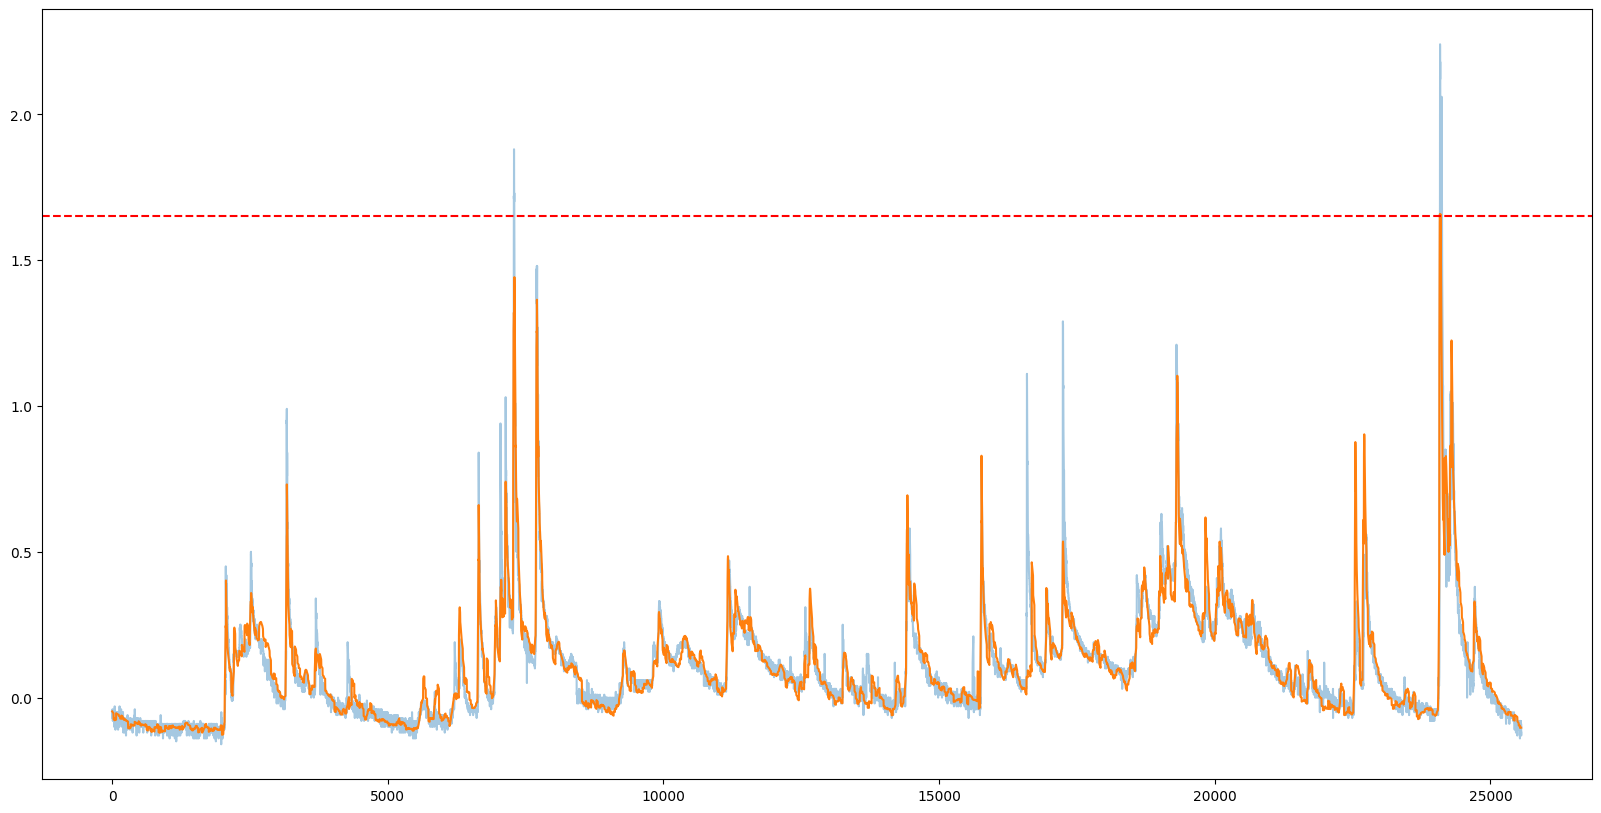

In [ ]:
# todos = [K1319_15,K10_16_21,K1218_17_22,K1420_11]
# '''INVERTO'''
todos = [K1218_17_22,K1319_15,K10_16_21,K1420_11]
#todos = [A14_15_10_22,A1218_16_17,A1320_11_19_21]
'''inverto'''
#todos = [A1218_16_17,A14_15_10_22,A1320_11_19_21]
#todos = [B1218_16,B10_15_17_22,B1319_21,B1420_11]
listone = []
matrice = []

for _ in range(1):
  counter = 0
  for i, K in enumerate(todos):

    train = pd.concat([K for j, K in enumerate(todos) if j!=i])
    test = K
    print(train.shape)
    if tipo == 'passato':
      X_train_new, y_train_new, X_test_new, y_test_new = reshape_without_waterflow(train, test, n_timesteps_in, n_timesteps_out)
      print(X_train_new.shape, y_train_new.shape)
      model = train_past(X_train_new, y_train_new, n_epochs, n_timesteps_out)
      results, obs, preds = test_past(model, X_test_new, y_test_new, soglia_2, margine)
      listone.append(results)
      dffone, matrix = calcolo_soglia_1(obs, preds, indeces, counter, soglia_1)
      matrice.append(matrix)
      counter += 1


    if tipo == 'portata':
      X_train_new, y_train_new, X_test_new, y_test_new = reshape_with_waterflow(train, test, n_timesteps_in, n_timesteps_out)
      print(X_train_new.shape, y_train_new.shape)
      model = train_past(X_train_new, y_train_new, n_epochs, n_timesteps_out)
      results, obs, preds = test_past(model, X_test_new, y_test_new, soglia_2, margine)
      listone.append(results)
      dffone, matrix = calcolo_soglia_1(obs, preds, indeces, counter, soglia_1)
      matrice.append(matrix)
      counter += 1
      break
    if tipo == 'previsioni':
      X_train_new, y_train_new, preds_train, X_test_new, y_test_new, preds_test = reshape_with_predictions(train, test, n_timesteps_in, n_timesteps_out)
      model = train_preds(X_train_new, preds_train, y_train_new, n_epochs, n_timesteps_out)
      results, obs, preds = test_preds(model, X_test_new,preds_train, y_test_new, soglia_2, margine)
      listone.append(results)
      dffone, matrix = calcolo_soglia_1(obs, preds, indeces, counter, soglia_1)
      matrice.append(matrix)
      counter += 1
      break


In [ ]:
#todos = [K1319_15,K10_16_21,K1218_17_22,K1420_11]
matrice

[(6, 0, 8, 1047)]

In [ ]:
listone

[(0.45234841108322144, -34.936973452568054, 0, 2, 0)]

In [ ]:
start_date = '2013-05-16'
end_date = '2013-05-18'

In [ ]:
dffone[dffone.obs>1.7]

,obs,preds
2012-11-08 14:00:00,1.72,1.320737
2012-11-08 15:00:00,1.71,1.320349
2012-11-08 16:00:00,1.71,1.316380
2012-11-08 17:00:00,1.88,1.308888
2012-11-08 18:00:00,1.79,1.297940
2012-11-08 21:00:00,1.73,1.245173
2018-10-25 18:00:00,2.09,1.647871
2018-10-25 19:00:00,2.24,1.635445
2018-10-25 20:00:00,2.12,1.618530
2018-10-25 21:00:00,2.18,1.597776


In [ ]:
df1[df1.PORT_305>1.7]

,ISTANTE,PREC_68,PREC_72,PREC_81,TEMP,UMID_MIN,UMID_MAX,RAD,PORT_305
7430,2012-11-11 14:00:00,5.4,2.2,4.4,12.9,100.0,100.0,0.019,1.72
7431,2012-11-11 15:00:00,2.4,1.0,0.6,13.4,100.0,100.0,0.000,1.71
7432,2012-11-11 16:00:00,1.4,1.4,0.6,13.4,100.0,100.0,0.000,1.71
7433,2012-11-11 17:00:00,0.2,0.0,0.0,13.4,99.0,100.0,0.000,1.88
7434,2012-11-11 18:00:00,0.4,0.8,0.6,13.4,99.0,100.0,0.000,1.79
7437,2012-11-11 21:00:00,0.0,0.0,0.0,12.1,99.0,99.0,0.000,1.73
24229,2018-10-28 18:00:00,0.8,0.4,1.6,11.3,100.0,100.0,0.000,2.09
24230,2018-10-28 19:00:00,0.2,0.0,0.0,11.0,100.0,100.0,0.000,2.24
24231,2018-10-28 20:00:00,0.0,0.0,0.0,10.4,100.0,100.0,0.000,2.12
24232,2018-10-28 21:00:00,0.0,0.0,0.0,10.0,100.0,100.0,0.000,2.18


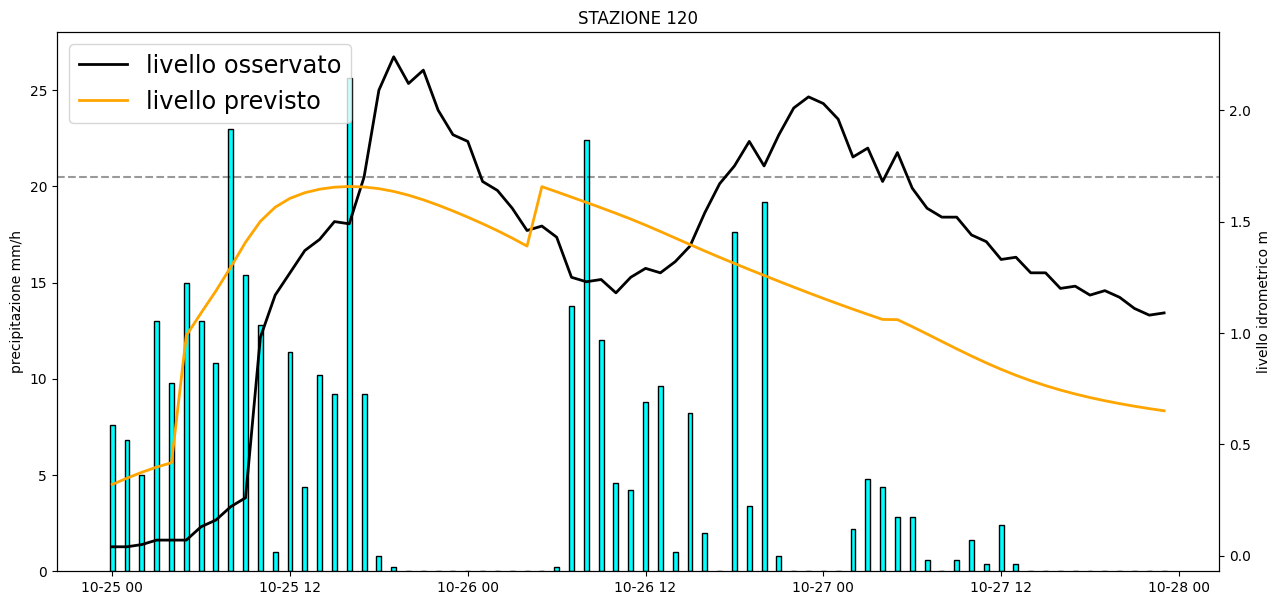

In [ ]:
from datetime import timedelta
widts = timedelta(minutes=20)
plt.figure(figsize=(15,7))
plt.bar(pd.date_range('2018-10-25','2018-10-28',freq='H')[:-1],df1.set_index('ISTANTE').loc['2018-10-28':'2018-10-31', 'PREC_68'],width=widts, color = 'cyan', edgecolor='black', label='percipitazione')
plt.ylim(top = 28)
plt.ylabel('precipitazione mm/h')
plt.title('STAZIONE 120')
ax1 = plt.twinx()
ax1.plot(pd.date_range('2018-10-25','2018-10-28',freq='H')[:-1],dffone.loc['2018-10-25':'2018-10-27', 'obs'], color = "black", lw=2, label='livello osservato')
ax1.plot(pd.date_range('2018-10-25','2018-10-28',freq='H')[:-1],dffone.loc['2018-10-25':'2018-10-27', 'preds'], color = "orange", lw=2, label='livello previsto')
ax1.set_ylabel('livello idrometrico m')
ax1.axhline(y=1.7, color='black',alpha=0.4, linestyle='--')
plt.legend(loc='upper left', fontsize= 'xx-large')

In [ ]:
df1.set_index('ISTANTE').loc[start_date:end_date+timedelta(hours=1)]

In [ ]:
end_date+timedelta(hours=1)

Timestamp('2013-05-18 01:00:00')

In [ ]:
start_date

Timestamp('2013-05-16 00:00:00')

In [ ]:
df1.set_index('ISTANTE').loc[start_date:end_date, 'PREC_68']

ISTANTE
2013-05-16 00:00:00     0.4
2013-05-16 01:00:00     0.2
2013-05-16 02:00:00     0.2
2013-05-16 03:00:00     0.6
2013-05-16 04:00:00     0.2
2013-05-16 05:00:00     0.6
2013-05-16 06:00:00     1.6
2013-05-16 07:00:00     9.4
2013-05-16 08:00:00    14.0
2013-05-16 09:00:00    12.4
2013-05-16 10:00:00    18.8
2013-05-16 11:00:00    21.8
2013-05-16 12:00:00    17.8
2013-05-16 13:00:00    12.6
2013-05-16 14:00:00    15.8
2013-05-16 15:00:00    12.6
2013-05-16 16:00:00     8.8
2013-05-16 17:00:00     6.0
2013-05-16 18:00:00     5.2
2013-05-16 19:00:00     7.2
2013-05-16 20:00:00    17.4
2013-05-16 21:00:00     8.8
2013-05-16 22:00:00     5.2
2013-05-16 23:00:00     0.0
2013-05-17 00:00:00     0.0
2013-05-17 01:00:00     0.2
2013-05-17 02:00:00     5.2
2013-05-17 03:00:00     3.4
2013-05-17 04:00:00    12.2
2013-05-17 05:00:00     8.2
2013-05-17 06:00:00     4.0
2013-05-17 07:00:00     7.6
2013-05-17 08:00:00    15.8
2013-05-17 09:00:00     9.8
2013-05-17 10:00:00     3.8
2013-05-17 1

In [ ]:
pd.date_range(start_date,end_date,freq='H')

DatetimeIndex(['2013-05-16 00:00:00', '2013-05-16 01:00:00',
               '2013-05-16 02:00:00', '2013-05-16 03:00:00',
               '2013-05-16 04:00:00', '2013-05-16 05:00:00',
               '2013-05-16 06:00:00', '2013-05-16 07:00:00',
               '2013-05-16 08:00:00', '2013-05-16 09:00:00',
               '2013-05-16 10:00:00', '2013-05-16 11:00:00',
               '2013-05-16 12:00:00', '2013-05-16 13:00:00',
               '2013-05-16 14:00:00', '2013-05-16 15:00:00',
               '2013-05-16 16:00:00', '2013-05-16 17:00:00',
               '2013-05-16 18:00:00', '2013-05-16 19:00:00',
               '2013-05-16 20:00:00', '2013-05-16 21:00:00',
               '2013-05-16 22:00:00', '2013-05-16 23:00:00',
               '2013-05-17 00:00:00', '2013-05-17 01:00:00',
               '2013-05-17 02:00:00', '2013-05-17 03:00:00',
               '2013-05-17 04:00:00', '2013-05-17 05:00:00',
               '2013-05-17 06:00:00', '2013-05-17 07:00:00',
               '2013-05-

In [ ]:
train = pd.read_csv('train_umido.csv')
test = pd.read_csv('test_secco.csv')

In [ ]:
train

,PREC_68,PREC_72,PREC_81,TEMP,UMID_MIN,UMID_MAX,RAD,PORT_305
0,0.0,0.0,0.0,2.5,100.0,100.0,0.0,0.21
1,0.0,0.0,0.0,2.0,100.0,100.0,0.0,0.20
2,0.2,0.0,0.0,1.5,100.0,100.0,0.0,0.21
3,0.0,0.0,0.0,0.5,100.0,100.0,0.0,0.20
4,0.0,0.0,0.0,0.3,100.0,100.0,0.0,0.20
...,...,...,...,...,...,...,...,...
75605,0.0,0.0,0.0,1.4,100.0,100.0,0.0,-0.21
75606,0.0,0.0,0.0,1.1,100.0,100.0,0.0,-0.21
75607,0.0,0.0,0.0,0.8,100.0,100.0,0.0,-0.20
75608,0.0,0.0,0.0,-0.2,100.0,100.0,0.0,-0.21


In [ ]:
tipo = 'passato'
#tipo = 'portata'
#tipo = 'previsioni'
'''
it's important you change the input_size based on your input AND RUN IT
'''
n_epochs = 30
n_timesteps_in = 72
n_timesteps_out = 24
input_size = 7
n_features_out = 1
hidden_size = 32
batch_size = 2048
soglia = 1.7
margine = 0.05

#todos = [K1319_15,K10_16_21,K1218_17_22,K1420_11]
#todos = [A14_15_10_22,A1218_16_17,A1320_11_19_21]
#todos = [B1218_16,B10_15_17_22,B1319_21,B1420_11]

In [ ]:
test = K1319_15
train = pd.concat([K10_16_21,K1218_17_22,K1420_11])

(25610, 72, 7)
(75514, 72, 7)
(75514, 72, 7) (75514, 24, 1) (25610, 72, 7)
onlyonce
Epoch - 1,  NSE_train - 0.3941 Loss - 0.033
Epoch - 2,  NSE_train - 0.4444 Loss - 0.032
Epoch - 3,  NSE_train - 0.4526 Loss - 0.034
Epoch - 4,  NSE_train - 0.503 Loss - 0.029
Epoch - 5,  NSE_train - 0.5596 Loss - 0.024
Epoch - 6,  NSE_train - 0.5421 Loss - 0.025
Epoch - 7,  NSE_train - 0.6144 Loss - 0.022
Epoch - 8,  NSE_train - 0.6099 Loss - 0.023
Epoch - 9,  NSE_train - 0.6343 Loss - 0.022
Epoch - 10,  NSE_train - 0.6599 Loss - 0.019
Epoch - 11,  NSE_train - 0.6362 Loss - 0.02
Epoch - 12,  NSE_train - 0.6645 Loss - 0.019
Epoch - 13,  NSE_train - 0.6809 Loss - 0.019
Epoch - 14,  NSE_train - 0.6854 Loss - 0.018
Epoch - 15,  NSE_train - 0.6983 Loss - 0.019
Epoch - 16,  NSE_train - 0.6884 Loss - 0.017
Epoch - 17,  NSE_train - 0.7102 Loss - 0.018
Epoch - 18,  NSE_train - 0.7186 Loss - 0.015
Epoch - 19,  NSE_train - 0.6998 Loss - 0.014
Epoch - 20,  NSE_train - 0.728 Loss - 0.016
Epoch - 21,  NSE_train - 0.7

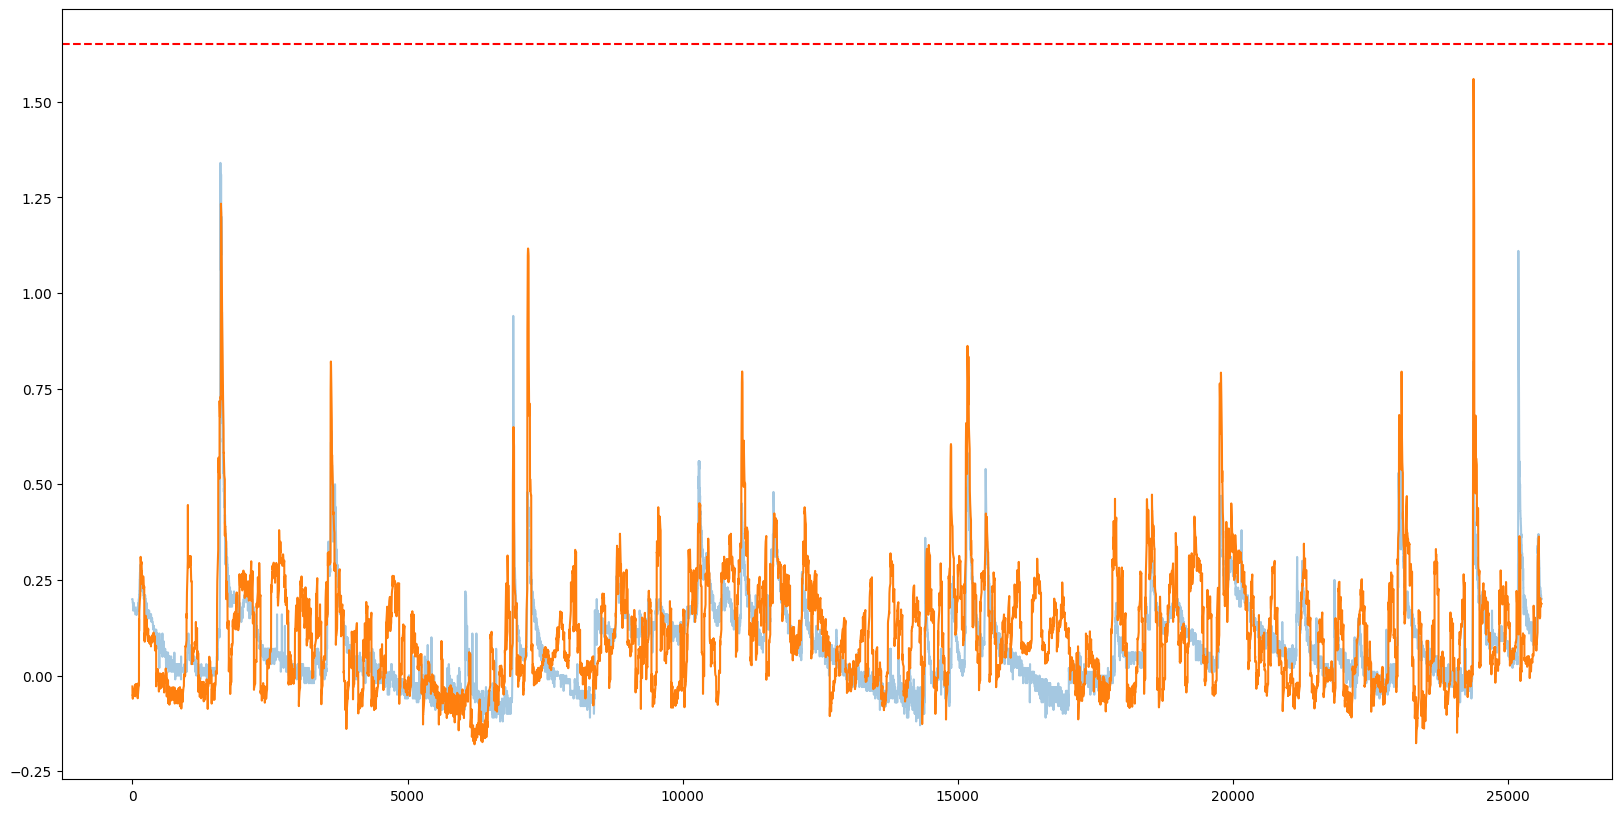

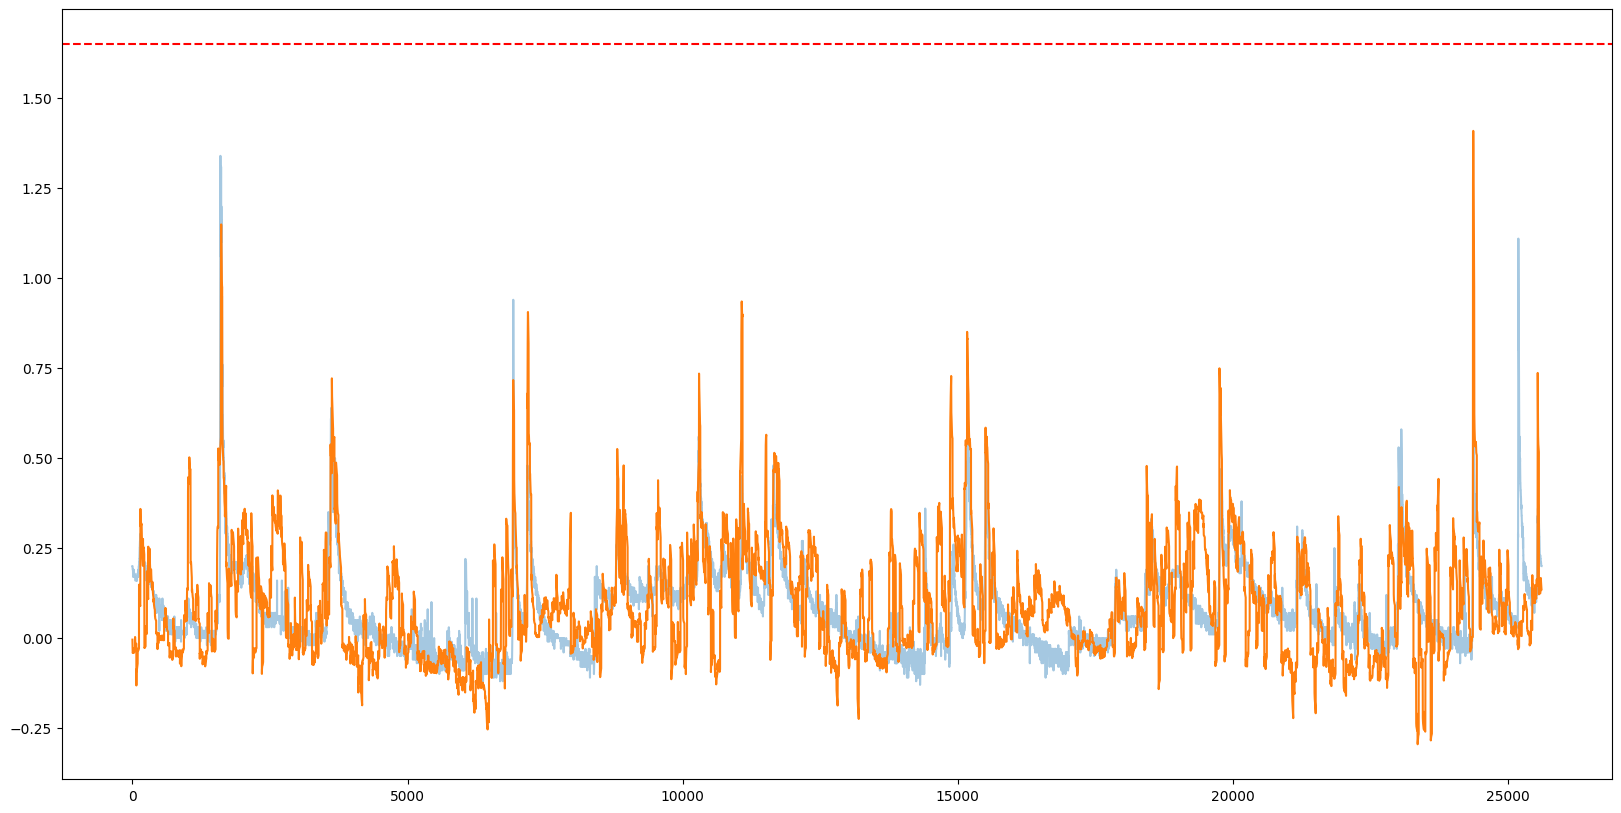

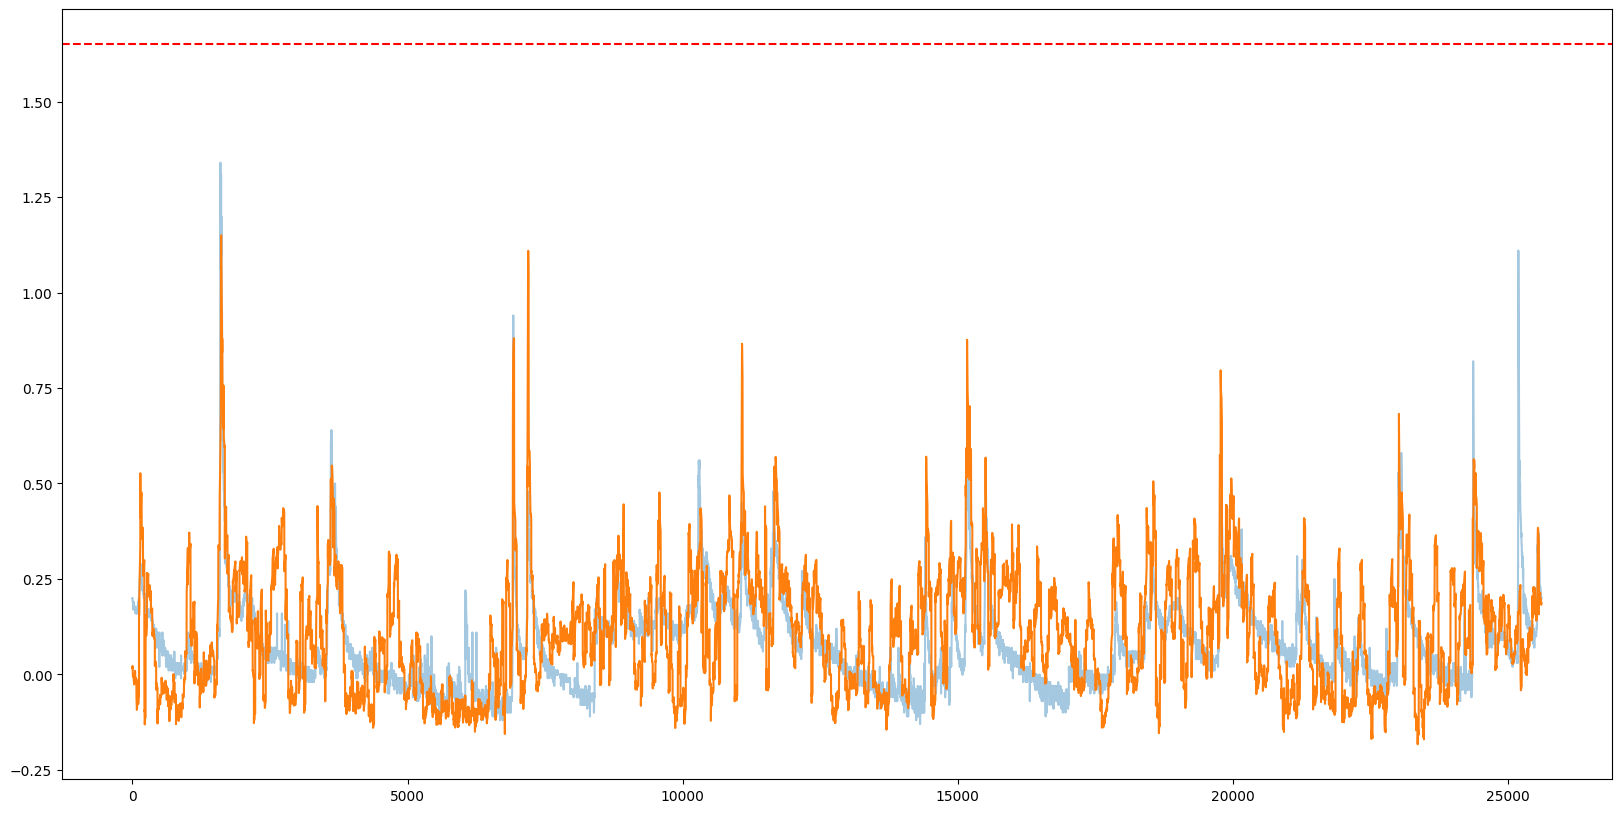

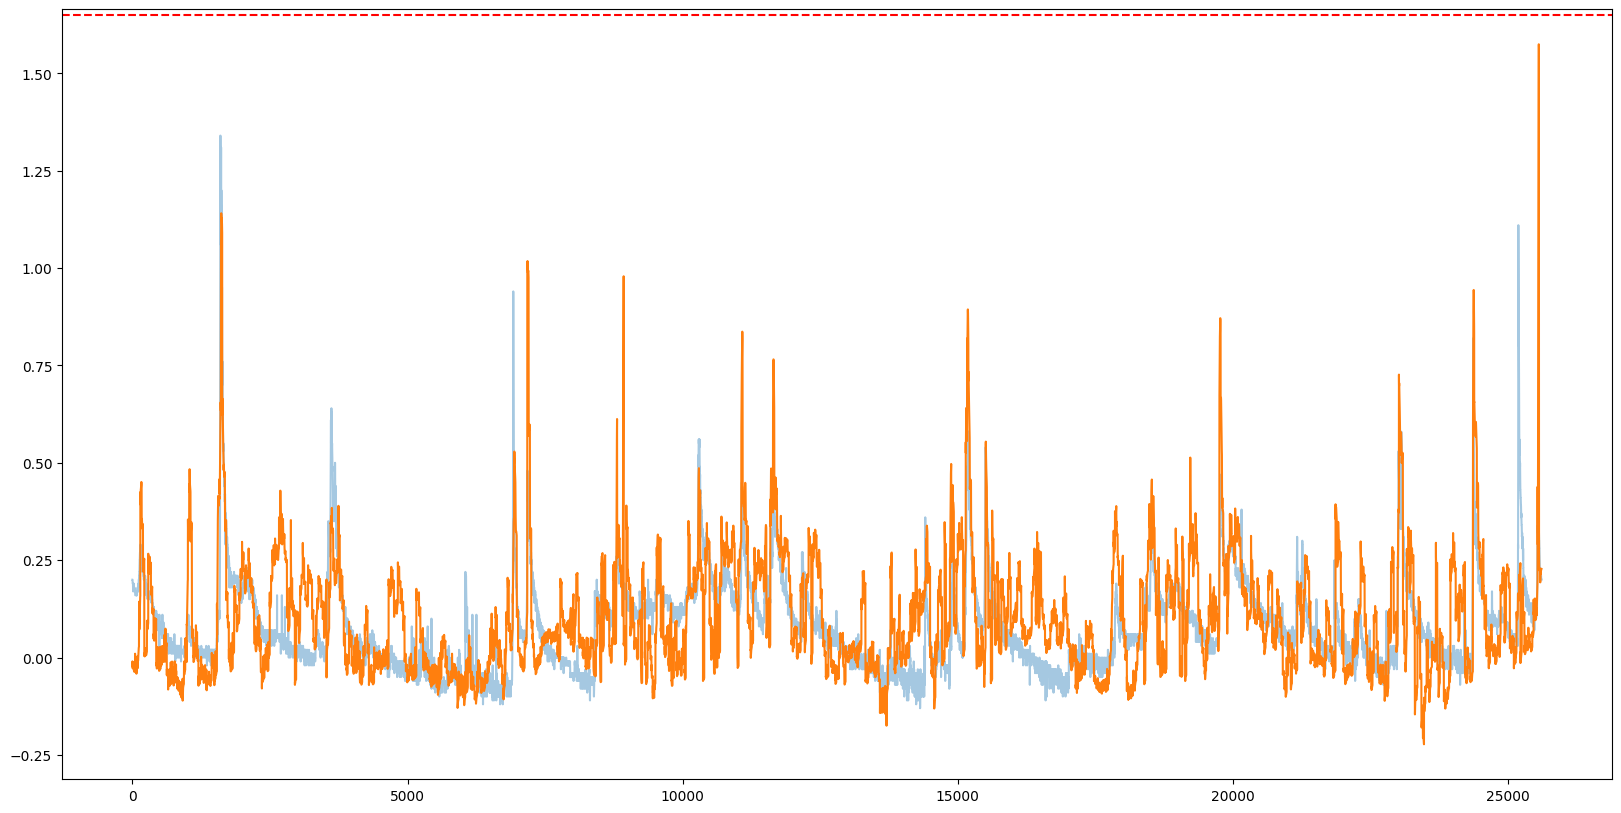

In [ ]:
listone = []
if tipo == 'passato':
  for i in range(4):
    X_train_new, y_train_new, X_test_new, y_test_new = reshape_without_waterflow(train, test, n_timesteps_in, n_timesteps_out)
    print(X_train_new.shape, y_train_new.shape, X_test_new.shape)
    model = train_past(X_train_new, y_train_new, n_epochs, n_timesteps_out)
    results, obs, preds = test_past(model, X_test_new, y_test_new, soglia, margine)
    listone.append(results)
if tipo == 'portata':
  X_train_new, y_train_new, X_test_new, y_test_new = reshape_with_waterflow(train, test, n_timesteps_in, n_timesteps_out)
  print(X_train_new.shape, y_train_new.shape, X_test_new.shape)
  model = train_past(X_train_new, y_train_new, n_epochs, n_timesteps_out)
  results, obs, preds = test_past(model, X_test_new, y_test_new, soglia, margine)
  listone.append(results)
if tipo == 'previsioni':
  X_train_new, y_train_new, preds_train, X_test_new, y_test_new, preds_test = reshape_with_predictions(train, test, n_timesteps_in, n_timesteps_out)
  print(X_train_new.shape, y_train_new.shape, preds_train.shape)
  model = train_preds(X_train_new, preds_train, y_train_new, n_epochs, n_timesteps_out)
  results, obs, preds = test_preds(model, X_test_new,preds_train, y_test_new, soglia, margine)
  listone.append(results)


In [ ]:
listone

[(-0.09427368640899658, 11.634470522403717, 0, 0, 0),
 (-0.23011672496795654, -0.8139300160109997, 0, 0, 0),
 (-0.2472590208053589, -2.7962788939476013, 0, 0, 0),
 (-0.04647815227508545, -1.3272440992295742, 0, 0, 0)]

In [ ]:
#devono essere ordinati secondo l'ordine in cui cicla todos
df1 = pd.read_csv('K1319_15_s687281_index.csv')
df2 = pd.read_csv('K10_16_21_s687281_index.csv')
df3 = pd.read_csv('K1218_17_22_s687281_index.csv')
df4 = pd.read_csv('K1420_11_s687281_index.csv')
indeces = [df1, df2, df3, df4]

In [ ]:
PP = 0
FP = 0
FN = 0
NN = 0
for day, day_data in dffone.groupby(dffone.index.date):
  superamento_previsto = np.any(day_data.preds.values > 1)
  superamento_reale = np.any(day_data.obs.values > 1)
  if superamento_reale and superamento_previsto:
    PP += 1
  if superamento_reale and not superamento_previsto:
    FN += 1
  if not superamento_reale and superamento_previsto:
    FP += 1
  if not superamento_reale and not superamento_previsto:
    NN += 1

In [ ]:
print(PP, FP, FN, NN)

7 1 7 1046
